In [1]:
import numpy as np

In [2]:
import  pandas as pd

In [3]:
electronic = pd.read_csv('ratings_Electronics.csv')

In [4]:
electronic.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
electronic.columns = ['User_ID', 'Product_ID', 'ratings', 'timestamp']

In [6]:
electronic.head()

,User_ID,Product_ID,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [7]:
electronic.drop('timestamp', axis = 1, inplace=True)

In [8]:
electronic.shape

(7824481, 3)

In [9]:
electronic.isnull().sum()

User_ID       0
Product_ID    0
ratings       0
dtype: int64

<string>Finding number of unique users, products and ratings:</string>

In [10]:
print(f'No. of Unique Users    :{electronic.User_ID.nunique()}')
print(f'No. of Unique Business :{electronic.Product_ID.nunique()}')
print(f'No. of Unique Ratings  :{electronic.ratings.nunique()}')


No. of Unique Users    :4201696
No. of Unique Business :476001
No. of Unique Ratings  :5


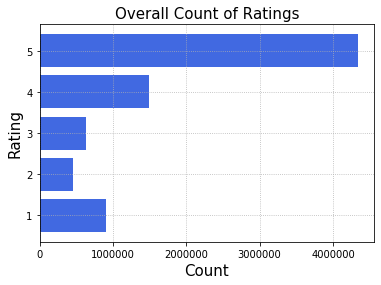

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

rts_gp = electronic.groupby(by=['ratings']).agg({'User_ID': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']

plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()


There is extreme skewness in the data. Most of the rating is 5

<strong>Building dataframe with users who have rated more than 50 times</strong>

In [12]:
counts = electronic['User_ID'].value_counts()
elec_df = electronic[~electronic['User_ID'].isin(counts[counts<=50].index)]

In [13]:
elec_df.shape

(122171, 3)

<strong>Subsetting that dataframe with products that have been rated more than 50 times</strong>

In [14]:
counts_1 = elec_df['Product_ID'].value_counts()
prod_df = elec_df[elec_df['Product_ID'].isin(counts_1[counts_1>50].index)]

In [15]:
prod_df.shape

(5770, 3)

In [16]:
Top_products = prod_df.groupby('Product_ID')['ratings'].mean().sort_values(ascending=False)

<strong>Popularity based model:</strong>

In [17]:
Top_products.head(5)

Product_ID
B0019EHU8G    4.894118
B001TH7GUU    4.864865
B003ES5ZUU    4.858757
B006W8U2MU    4.821429
B000QUUFRW    4.804878
Name: ratings, dtype: float64

<strong>Personalized Recommendation model:</strong>

In [18]:
from surprise import KNNWithMeans
from surprise import Dataset,Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [19]:
reader = Reader(rating_scale=(1.0,5.0))

In [20]:
data = Dataset.load_from_df(elec_df[['User_ID','Product_ID','ratings']], reader)

In [21]:
trainset, testset = train_test_split(data, test_size=0.3, random_state=5)

In [22]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True}, verbose=True)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [23]:
test_pred = algo.test(testset)

In [24]:
accuracy.rmse(test_pred)

RMSE: 1.0542


1.0541922641326023

<strong>For the user: A3HPCRD9RX351S, Recommending 5 products</strong>

In [25]:
top_recommendation = algo.get_neighbors(trainset.to_inner_uid('A3HPCRD9RX351S'),k=5)

In [26]:
[trainset.to_raw_iid(x) for x in top_recommendation]

['B0079T722O', 'B005058B56', 'B006WHPQD6', 'B001C53ZWM', 'B005JX4CTS']

<strong>Cross validation:</strong>

In [27]:
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [28]:
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60], 'sim_options' : {'name': ['pearson_baseline','cosine'], 'user_based': [True]}}
knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs.fit(data)

In [29]:
knnmeans_gs.best_score['rmse']

1.054019410676655

In [30]:
knnmeans_gs.best_params['rmse']

{'k': 50, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}

In [31]:
knnmeans_cv = cross_validate(KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True}), data, cv=5, n_jobs=5, verbose=False)

In [32]:
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))

KNN Means 	 1.0542 	 0.7728


<strong>The RMSE is 1.0542</strong>

The model is able to predict the rating of a new user with an average error of 1.05 rating